In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
from collections import defaultdict, deque

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import numpy as np
import pandas as pd
from glob import glob
import sys
sys.path.append('../src/')
from parsing import Parse
from training import TrainingOrders
from buildings import BuildOrders
datasetfolder = "i:/StarCraft_BO/replayActionList/*"
datasetfiles = glob(datasetfolder)

In [16]:
from buildings import protoss_buildings, zerg_buildings, terran_buildings
from training import protoss_units, zerg_units, terran_units

In [3]:
sc = Parse(datasetfiles[1])

In [6]:
sc.extract_training(1)[:10]

[('76', 'SCV'),
 ('1112', 'SCV'),
 ('1136', 'SCV'),
 ('1876', 'SCV'),
 ('2576', 'SCV'),
 ('4228', 'SCV'),
 ('4240', 'SCV'),
 ('4252', 'SCV'),
 ('4872', 'SCV'),
 ('6736', 'SCV')]

To cluster build orders, we will convert games into matrix of train/build frames for each units/buildings. The max queue to store can be a parameter. 
The distances between builds will be the average absolute differences. The dataset will be split into :  

|x|P|Z|T|
|-|-|-|-|
|P|PvP|PvZ|PvT|
|Z|ZvP|ZvZ|ZvT|
|T|TvP|TvZ|TvT|

In [80]:
bo_dict = {}
for race in ['Protoss','Zerg', 'Terran']:
    bo = BuildOrders(race,datasetfiles, nb_bo=100)
    b = bo.select_bo()
    b.extend(bo.select_bo(winners=False))
    bo_dict[race] = b

In [81]:
to_dict = {}
for race in ['Protoss','Zerg', 'Terran']:
    to = TrainingOrders(race, datasetfiles, nb_to=100)
    t = to.select_to()
    t.extend(to.select_to(winners=False))
    to_dict[race] = t

In [82]:
protoss_builds = []
for i,pb in enumerate(bo_dict['Protoss']):
    builds = {}
    for build in protoss_buildings:
        builds[build] = deque([0.0]*10, 10)
    for line in pb:
        builds[line[1]].appendleft(int(line[0]))
    a = pd.DataFrame.from_dict(builds)
    protoss_builds.append(a.values)

In [83]:
len(protoss_builds)

56

### Distance matrix

In [85]:
mat = np.zeros((len(protoss_builds), len(protoss_builds)))
for i,a in enumerate(protoss_builds):
    for j,b in enumerate(protoss_builds):
        mat[i,j] = np.mean(np.abs(a - b))

In [86]:
mat

array([[    0.        , 16076.66666667, 12485.49333333, ...,
        15661.09333333, 10341.97333333, 13888.88      ],
       [16076.66666667,     0.        ,  4046.32      , ...,
          415.57333333, 15741.14666667,  4740.10666667],
       [12485.49333333,  4046.32      ,     0.        , ...,
         3630.74666667, 12540.42666667,  5270.58666667],
       ...,
       [15661.09333333,   415.57333333,  3630.74666667, ...,
            0.        , 15325.57333333,  4406.29333333],
       [10341.97333333, 15741.14666667, 12540.42666667, ...,
        15325.57333333,     0.        , 11134.26666667],
       [13888.88      ,  4740.10666667,  5270.58666667, ...,
         4406.29333333, 11134.26666667,     0.        ]])

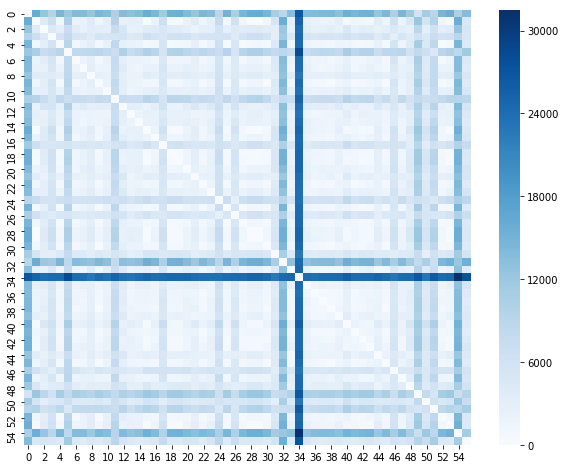

In [105]:
plt.figure(figsize=(10,8))
sns.heatmap(mat, cmap='Blues')
plt.show()

### Clusters

In [96]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [97]:
X = StandardScaler().fit_transform(mat)
db = DBSCAN().fit(X)

In [98]:
db.labels_

array([-1,  1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  1, -1,
       -1, -1,  1, -1, -1, -1, -1, -1,  0, -1,  0,  1,  1,  0, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0,  1, -1, -1], dtype=int64)

In [100]:
np.where(db.labels_ == 0)

(array([ 4,  9, 25, 27, 30, 52], dtype=int64),)

In [111]:
np.where(db.labels_ == 1)[0]

array([ 1, 15, 19, 28, 29, 53], dtype=int64)

In [121]:
bo_dict['Protoss'][34]

[('3372', 'Pylon', 47.0, 109.0, None),
 ('6424', 'Gateway', 42.5, 107.5, None),
 ('8460', 'Assimilator', 42.5, 123.5, None),
 ('10756', 'CyberneticsCore', 45.5, 105.5, None),
 ('11948', 'Pylon', 46.0, 111.0, None),
 ('14320', 'Assimilator', 56.5, 124.5, None),
 ('14940', 'RoboticsFacility', 50.5, 114.5, None),
 ('23268', 'Gateway', 41.5, 112.5, None),
 ('27192', 'Pylon', 142.0, 71.0, None),
 ('39548', 'Pylon', 111.0, 78.0, None),
 ('67588', 'Nexus', 26.5, 56.5, None),
 ('84376', 'Nexus', 34.5, 95.5, None),
 ('86908', 'TwilightCouncil', 58.5, 117.5, None),
 ('88664', 'Pylon', 46.0, 95.0, None),
 ('102312', 'RoboticsBay', 60.5, 124.5, None),
 ('110188', 'Nexus', 41.5, 29.5, None),
 ('112212', 'Pylon', 118.0, 75.0, None),
 ('120328', 'Nexus', 63.5, 53.5, None),
 ('187004', 'Nexus', 72.5, 100.5, None),
 ('208340', 'DarkShrine', 59.0, 61.0, None),
 ('222428', 'TemplarArchives', 38.5, 94.5, None),
 ('223168', 'FleetBeacon', 56.5, 106.5, None),
 ('244932', 'Nexus', 93.5, 124.5, None),
 ('2451